In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import sys
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [115]:
from src.data.download_oecd_ilo import get_industry_employment_data, oecd_api_wrapper
from src.data.download_comtrad import get_un_trade_data

In [116]:
UN_API_KEY = "<YOUR_KEY>"

# A. Set file path to parent directory

In [117]:
sys.path.append(str(Path().resolve().parent / "src"))
os.chdir("../")

# 1. Import employment data from ILO

## 1.A Import

In [118]:
df_ilo = get_industry_employment_data(start_year=2000, end_year=2023, output_filename="ilo_data_raw.csv")
df_ilo.head(2)

Fetching ILO data from: https://rplumber.ilo.org/data/indicator/?id=EMP_TEMP_ECO_OCU_NB_A&timefrom=2000&timeto=2023&classif1=ECO_SECTOR_IND&classif2=OCU_SKILL_TOTAL&format=.csv
Saving the dataset to: ilo_data_raw.csv


,ref_area,source,indicator,classif1,classif2,time,obs_value,obs_status,note_classif,note_indicator,note_source
0,ABW,AA:22,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2010,6.738,NaN,NaN,NaN,S3:20_T2:83
1,AFG,BA:15715,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2021,1463.372,NaN,NaN,NaN,R1:3513_S3:8


## 1.1 Inspect data

In [119]:
df_ilo.ref_area.unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH',
       'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA',
       'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU',
       'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FSM', 'GBR', 'GEO', 'GHA', 'GMB', 'GNB',
       'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KOS', 'LAO',
       'LBN', 'LBR', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT',
       'MMR', 'MNE', 'MNG', 'MOZ', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA', 'NIC', 'NIU', 'NLD', 'NOR', 'NPL', 'NRU', 'OMN',
       'PAK', 'PAN',

## 1.2 Truncate data

In [121]:
df_ilo_extract = df_ilo.loc[:, ["ref_area", "time", "obs_value"]]
df_ilo_extract.head(2)

,ref_area,time,obs_value
0,ABW,2010,6.738
1,AFG,2021,1463.372


In [122]:
def_ilo_renamed = df_ilo_extract.rename({"ref_area": "country", "time": "year", "obs_value": "ILO"}, axis="columns")
df_ilo_clean = def_ilo_renamed.set_index(["country", "year"])
df_ilo_clean.head(2)

,,ILO
country,year,
ABW,2010,6.738
AFG,2021,1463.372


# 2. Import trade data from UN Comtrade

In [123]:
df_un_trade = get_un_trade_data(UN_API_KEY)
df_un_trade.head(2)

/Users/quentin/Documents/Development/graspp-25S-trade/src/data/download_comtrad.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(list_df)


,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,19880101,1988,52,1988,36,AUS,Australia,M,...,NaN,False,NaN,False,NaN,3.302574e+10,3.302574e+10,0,False,False
1,C,A,19880101,1988,52,1988,36,AUS,Australia,X,...,NaN,False,NaN,False,NaN,3.220539e+10,3.220539e+10,0,False,False


In [128]:
df_trade_extract = df_un_trade[['reporterISO', 'refYear', 'primaryValue', 'flowDesc']].dropna()
df_trade_rename = df_trade_extract.rename({"reporterISO":'country', "refYear":'year', "primaryValue":'total trade value',"flowDesc":'import or export'}, axis=1)
df_trade_clean = df_trade_rename.pivot(index=['country', 'year'], columns="import or export", values="total trade value")

df_trade_clean.info()
df_trade_clean.head(2)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5198 entries, ('ABW', np.int64(2000)) to ('ZWE', np.int64(2024))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Export  5143 non-null   float64
 1   Import  5164 non-null   float64
dtypes: float64(2)
memory usage: 107.6+ KB


import or export       Export       Import
country year                              
ABW     2000      172999090.0  835229439.0
        2001      148856140.0  836234454.0

In [129]:
df_merge = pd.merge(
    df_trade_clean,
    df_ilo_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.tail(2)

Export        Import      ILO
country year                                     
ZWE     2022  6.586208e+09  8.603710e+09  662.185
        2023  7.225586e+09  9.201594e+09  627.991

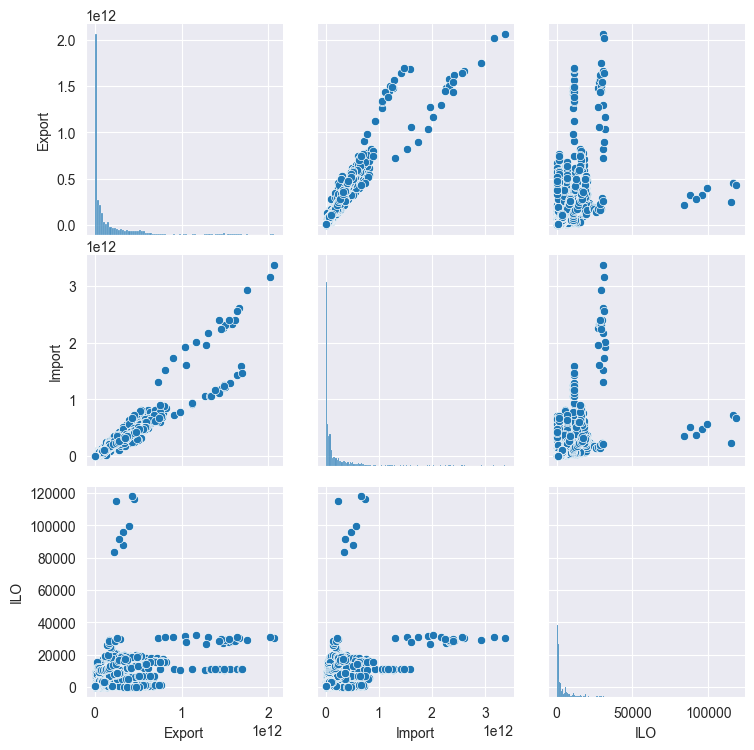

In [130]:
g = sns.PairGrid(df_merge)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

#Conducting Regression Analysis - Wanonno Iqtyider

                            OLS Regression Results                            
Dep. Variable:            Q("Export")   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     463.6
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           4.12e-92
Time:                        19:26:59   Log-Likelihood:                -51975.
No. Observations:                1886   AIC:                         1.040e+05
Df Residuals:                    1884   BIC:                         1.040e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.997e+10   5.61e+09     16.034      0.0

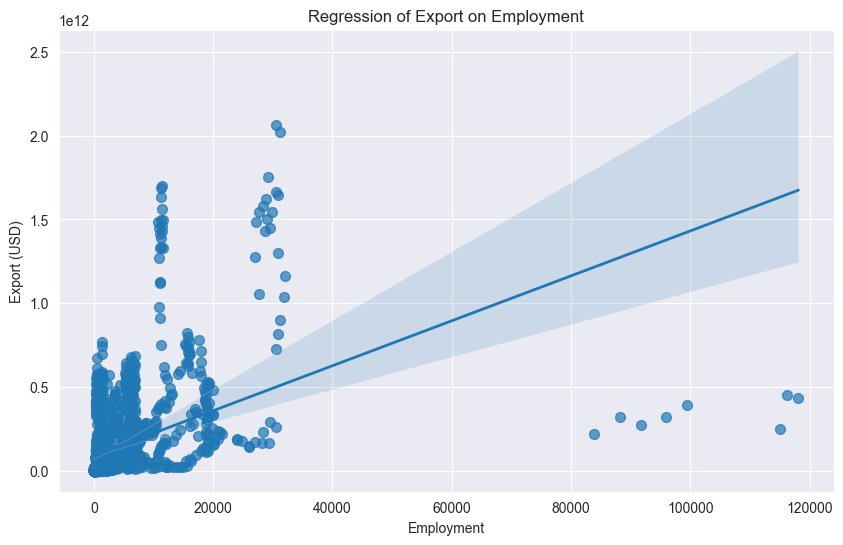

In [131]:
# 2. Prepare the data
# Make sure 'employment' and 'total trade value' exist without NaNs
df_regression = df_merge.dropna(subset=["Export", "ILO"]).reset_index()

# 3. Run the regression using formula
# Note: you need to handle spaces in column names by using `Q("column name")` inside the formula
model = smf.ols(formula='Q("Export") ~ ILO', data=df_regression).fit()

# 4. Print regression summary
print(model.summary())

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_regression,
    x="ILO",
    y="Export",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"linewidth":2}
)
plt.title('Regression of Export on Employment')
plt.xlabel('Employment')
plt.ylabel('Export (USD)')
plt.grid(True)
plt.show()
